In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

C:\Users\82104\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load data
train = pd.read_csv("./train.csv", index_col=0)
test = pd.read_csv("./test.csv", index_col=0)
submission = pd.read_csv("./sample_submission.csv")

In [3]:
#유용한 값들 추가
train['u-g'] = train['u'] - train['g']
train['g-r'] = train['g'] - train['r']
train['r-i'] = train['r'] - train['i']
train['i-z'] = train['i'] - train['z']
train['dered_u-g'] = train['dered_u'] - train['dered_g']
train['dered_g-r'] = train['dered_g'] - train['dered_r']
train['dered_r-i'] = train['dered_r'] - train['dered_i']
train['dered_i-z'] = train['dered_i'] - train['dered_z']

test['u-g'] = test['u'] - test['g']
test['g-r'] = test['g'] - test['r']
test['r-i'] = test['r'] - test['i']
test['i-z'] = test['i'] - test['z']
test['dered_u-g'] = test['dered_u'] - test['dered_g']
test['dered_g-r'] = test['dered_g'] - test['dered_r']
test['dered_r-i'] = test['dered_r'] - test['dered_i']
test['dered_i-z'] = test['dered_i'] - test['dered_z']

In [4]:
train = train.drop(['nObserve', 'nDetect', 'airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z'], axis=1)
test = test.drop(['nObserve', 'nDetect', 'airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z'], axis=1)

In [5]:
# split data into X and y
Y = train['class']
del train['class']
X = train

In [7]:
#train-test-split
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.25, random_state=0)

In [8]:
# scale features
scaler = RobustScaler()
scaler.fit(X_train) # fit scaler to training data only
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_validation = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test = pd.DataFrame(scaler.transform(test), columns=test.columns)

# # apply principal component analysis to wavelength intensities
# pca = PCA(n_components=3)
# dfs = [X_train, X_validation, X_test]
# for i in range(len(dfs)):
#     df = dfs[i]
#     ugriz = pca.fit_transform(df[['u', 'g', 'r', 'i', 'z']])
#     df = pd.concat((df, pd.DataFrame(ugriz)), axis=1)
#     df.rename({0: 'PCA1', 1: 'PCA2', 2: 'PCA3'}, axis=1, inplace=True)
#     df.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
#     dfs[i] = df
# X_train, X_validation, X_test = dfs

# create a random forest model
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_validation)
model_acc = (preds == y_test).sum().astype(float) / len(preds) * 100

print('Validation Accuracy: %3.5f' % (model_acc))

Validation Accuracy: 93.45125


           Importance
Feature              
redshift     0.369101
dered_r-i    0.084827
dered_u-g    0.066737
g-r          0.055840
u-g          0.054122
dered_i-z    0.050383
r-i          0.048287
dered_g-r    0.040863
r            0.040565
i-z          0.031274
i            0.027704
u            0.027199
dered_u      0.021755
dered_r      0.019763
z            0.014506
dered_i      0.014403
g            0.011614
dered_g      0.011061
dered_z      0.009995


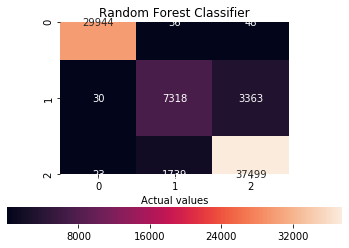

Recall:  [0.99823316 0.8047949  0.91662185]
Precision:  [0.99720261 0.68322286 0.95512086]


In [9]:
# analyze feature importance in random forest model
importances = pd.DataFrame({
    'Feature': X_validation.columns,
    'Importance': rfc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
print(importances)

# plot confusion matrices for both models
labels = np.unique(Y)

ax = plt.subplot(1, 1, 1)
ax.set_aspect(1)
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = labels,
            yticklabels = labels, cbar_kws={'orientation': 'horizontal'})
plt.xlabel('Actual values')
plt.title('Random Forest Classifier')

plt.show()

# compute precision and recall
precision = np.diag(cm) / np.sum(cm, axis = 0)
recall = np.diag(cm) / np.sum(cm, axis = 1)

print('Recall: ', precision)
print('Precision: ', recall)

In [11]:
# pred = rfc.predict(X_test)
# submission['class'] = pred
# submission.to_csv("submission_rf.csv",index=False, encoding='utf-8-sig')